In [1]:
#PyTorch 버전과 CUDA 정보 출력
import torch
print(torch.__version__)           # PyTorch 버전 출력
print(torch.cuda.is_available())   # CUDA 사용 가능 여부 출력
print(torch.version.cuda)          # CUDA 버전 출력

2.3.0+cu121
True
12.1


In [2]:
#PyTorch 및 CUDA 관련 정보 상세 출력
import torch
import torch

print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

PyTorch version: 2.3.0+cu121
CUDA version: 12.1
cuDNN version: 8801
CUDA available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 2060


In [3]:
%pip install numpy
%pip install torch
%pip install pydicom
%pip install matplotlib
%pip install monai
%pip install rt-utils
%pip install scipy
%pip install tcia_utils
%pip install nibabel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
#필요한 라이브러리 임포트
import os
import numpy as np
import torch
import pydicom
import matplotlib.pyplot as plt
from tcia_utils import nbia
from monai.bundle import ConfigParser, download
from monai.transforms import LoadImage, LoadImaged, Orientation, Orientationd, EnsureChannelFirst, EnsureChannelFirstd, Compose
from rt_utils import RTStructBuilder
from scipy.ndimage import label, measurements
import json

In [4]:
datadir = r"C:\Users\bkyou\datadir"

In [5]:
# NBIA에서 데이터 다운로드
cart_name = "nbia-61031717499907586"
cart_data = nbia.getSharedCart(cart_name)
df = nbia.downloadSeries(cart_data, format="df", path = datadir)

2024-06-08 13:50:17,866:INFO:Calling... https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName with parameters {'name': 'nbia-61031717499907586'}
2024-06-08 13:50:19,354:INFO:Downloading 1 Series Instance UIDs (scans).
2024-06-08 13:50:20,668:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.1600.1201.312087933416130338402619297252 already downloaded.
2024-06-08 13:50:20,669:INFO:Downloaded 0 out of 1 Series Instance UIDs (scans).
0 failed to download.
1 previously downloaded.


In [6]:
# CT 폴더 경로 설정
CT_folder = os.path.join(datadir, '1.3.6.1.4.1.14519.5.2.1.1600.1201.312087933416130338402619297252')

In [7]:
# DICOM 파일 로드
ds = pydicom.read_file(os.path.join(CT_folder, '1-200.dcm'))

In [8]:
# 이미지 데이터 추출 및 전처리
image = ds.pixel_array
image.shape

(512, 512)

In [9]:
# 이미지 데이터 스케일 조정
image = ds.RescaleSlope * image + ds.RescaleIntercept # 이미지 데이터를 HU 단위로 변환

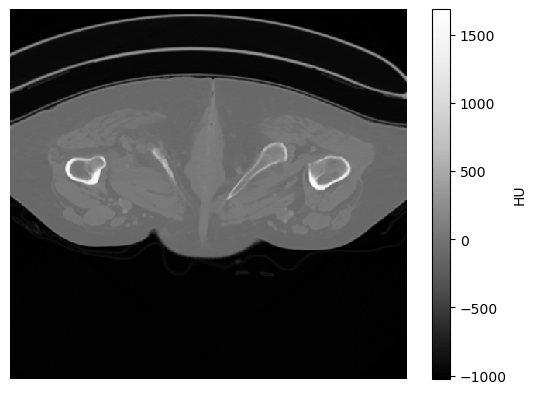

In [10]:
# 이미지 시각화
plt.pcolormesh(image, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [11]:
# 이미지 로더 정의
image_loader = LoadImage(image_only=True)
CT = image_loader(CT_folder)

C:\Users\bkyou\anaconda3\Lib\site-packages\monai\transforms\io\array.py:255: UserWarning: Failed to read C:\Users\bkyou\datadir\1.3.6.1.4.1.14519.5.2.1.1600.1201.312087933416130338402619297252\LICENSE with exception: 
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading..
  img = reader.read(filename)


In [12]:
# 메타 데이터 출력
CT.meta

{'00200037': {'vr': 'DS', 'Value': [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]},
 '00200032': {'vr': 'DS', 'Value': [-176.623046875, -338.623046875, 961.8]},
 '00280030': {'vr': 'DS', 'Value': [0.75390625, 0.75390625, 3.0]},
 'spacing': array([0.75390625, 0.75390625, 3.        ]),
 'lastImagePositionPatient': array([-176.62304688, -338.62304688,  310.8       ]),
 spatial_shape: (512, 512, 218),
 space: RAS,
 original_affine: array([[-7.53906250e-01,  0.00000000e+00,  0.00000000e+00,
          1.76623047e+02],
        [ 0.00000000e+00, -7.53906250e-01,  0.00000000e+00,
          3.38623047e+02],
        [ 0.00000000e+00,  0.00000000e+00, -3.00000000e+00,
          9.61800000e+02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 affine: tensor([[-7.5391e-01,  0.0000e+00,  0.0000e+00,  1.7662e+02],
         [ 0.0000e+00, -7.5391e-01,  0.0000e+00,  3.3862e+02],
         [ 0.0000e+00,  0.0000e+00, -3.0000e+00,  9.6180e+02],
         [ 0.0000e+00,  0.0000e+00,  0

In [13]:
CT_coronal_slice = CT[:,256].cpu().numpy()

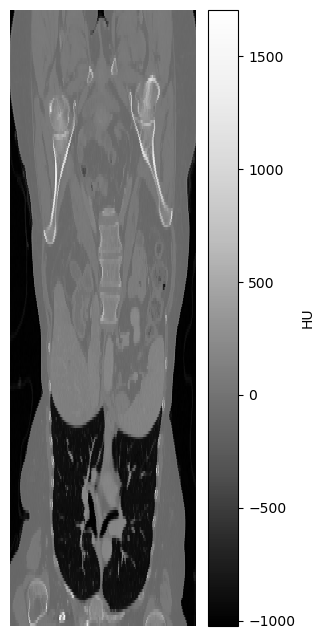

In [14]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [15]:
# CT 이미지의 형태 출력
CT.shape

torch.Size([512, 512, 218])

In [16]:
# 채널 변환
channel_transform = EnsureChannelFirst()
CT = channel_transform(CT)
CT.shape

torch.Size([1, 512, 512, 218])

In [17]:
orientation_transform = Orientation(axcodes=('LPS'))
CT = orientation_transform(CT)

In [18]:
CT_coronal_slice = CT[0,:,256].cpu().numpy()

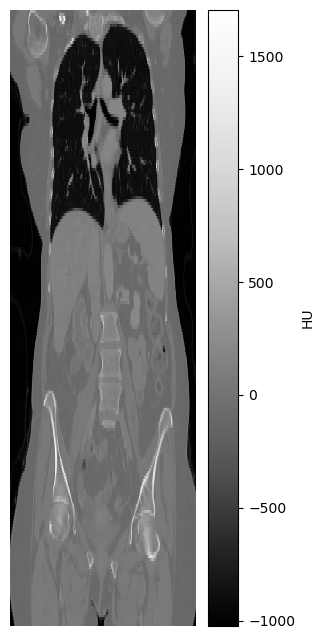

In [19]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [20]:
# 전처리 과정 정의 및 적용
preprocessing_pipeline = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Orientation(axcodes='LPS')
])

In [21]:
CT = preprocessing_pipeline(CT_folder)
CT_coronal_slice = CT[0,:,256].cpu().numpy()

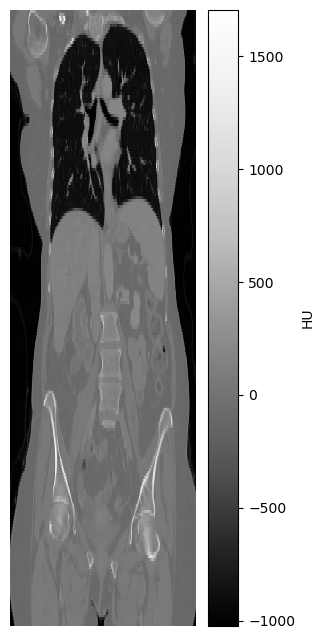

In [22]:
plt.figure(figsize=(3,8))
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.colorbar(label='HU')
plt.axis('off')
plt.show()

In [23]:
data = {'image': CT_folder, 'some_other_key': 42}

In [24]:
preprocessing_pipeline = Compose([
    LoadImaged(keys='image', image_only=True),
    EnsureChannelFirstd(keys='image'),
    Orientationd(keys='image',axcodes='LPS')
])

In [25]:
data = preprocessing_pipeline(data)

In [26]:
data

{'image': metatensor([[[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           ...,
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]],
 
          [[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
           

In [27]:
# 모델 이름과 데이터 디렉토리 설정
model_name = "wholeBody_ct_segmentation"
download(name=model_name, bundle_dir=datadir)

2024-06-08 13:50:51,711 - INFO - --- input summary of monai.bundle.scripts.download ---
2024-06-08 13:50:51,717 - INFO - > name: 'wholeBody_ct_segmentation'
2024-06-08 13:50:51,720 - INFO - > bundle_dir: 'C:\\Users\\bkyou\\datadir'
2024-06-08 13:50:51,722 - INFO - > source: 'monaihosting'
2024-06-08 13:50:51,724 - INFO - > remove_prefix: 'monai_'
2024-06-08 13:50:51,726 - INFO - > progress: True
2024-06-08 13:50:51,727 - INFO - ---


2024-06-08 13:50:52,803 - INFO - Expected md5 is None, skip md5 check for file C:\Users\bkyou\datadir\wholeBody_ct_segmentation_v0.2.4.zip.
2024-06-08 13:50:52,803 - INFO - File exists: C:\Users\bkyou\datadir\wholeBody_ct_segmentation_v0.2.4.zip, skipped downloading.
2024-06-08 13:50:52,803 - INFO - Writing into directory: C:\Users\bkyou\datadir.


In [28]:
# 모델 경로와 설정 파일 경로 설정
model_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'models', 'model_lowres.pt')
config_path = os.path.join(datadir, 'wholeBody_ct_segmentation', 'configs', 'inference.json')

In [29]:
# 설정 파일 읽기
config = ConfigParser()
config.read_config(config_path)

In [30]:
# 전처리 파이프라인 가져오기
preprocessing = config.get_parsed_content("preprocessing")

In [31]:
# 데이터 전처리 수행
data = preprocessing({'image': CT_folder})

In [32]:
# 네트워크 모델 정의
model = config.get_parsed_content("network")

In [33]:
# 모델 가중치 로드
model.load_state_dict(torch.load(model_path))
model.eval(); # 모델을 평가 모드로 설정

In [34]:
# 추론기 정의
inferer = config.get_parsed_content("inferer")

In [35]:
# 후처리 파이프라인 가져오기
postprocessing = config.get_parsed_content("postprocessing")

In [36]:
# 데이터 형태 확인
data['image'].unsqueeze(0).shape

torch.Size([1, 1, 258, 258, 435])

In [37]:
import torch

def print_gpu_memory():
    # 현재 사용 중인 GPU 메모리
    allocated = torch.cuda.memory_allocated() / (1024 ** 3)
    # 캐시된 메모리
    cached = torch.cuda.memory_reserved() / (1024 ** 3)
    # 전체 GPU 메모리
    total_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
    
    print(f"Allocated Memory: {allocated:.2f} GB")
    print(f"Cached Memory: {cached:.2f} GB")
    print(f"Total Memory: {total_memory:.2f} GB")

# GPU 메모리 정보 출력
print_gpu_memory()


Allocated Memory: 0.07 GB
Cached Memory: 0.19 GB
Total Memory: 6.00 GB


In [39]:
import torch

if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please check your CUDA installation.")

# 모델을 CUDA로 이동
model = model.cuda()
data['image'] = data['image'].cuda()

# 2. Compute mask prediction, add it to dictionary
with torch.no_grad():
    # Have to add additional batch dimension to feed into model
    data['pred'] = inferer(data['image'].unsqueeze(0), network=model)
# Remove batch dimension in image and prediction
data['pred'] = data['pred'][0]
data['image'] = data['image'][0]
# Apply postprocessing to data
data = postprocessing(data)
segmentation = torch.flip(data['pred'][0], dims=[2])
segmentation = segmentation.cpu().numpy()


OutOfMemoryError: CUDA out of memory. Tried to allocate 108.00 MiB. GPU 

In [53]:
# 특정 슬라이스 인덱스 설정 및 시각화용 데이터 준비
slice_idx = 250
CT_coronal_slice = CT[0,:,slice_idx].cpu().numpy()
segmentation_coronal_slice = segmentation[:,slice_idx]

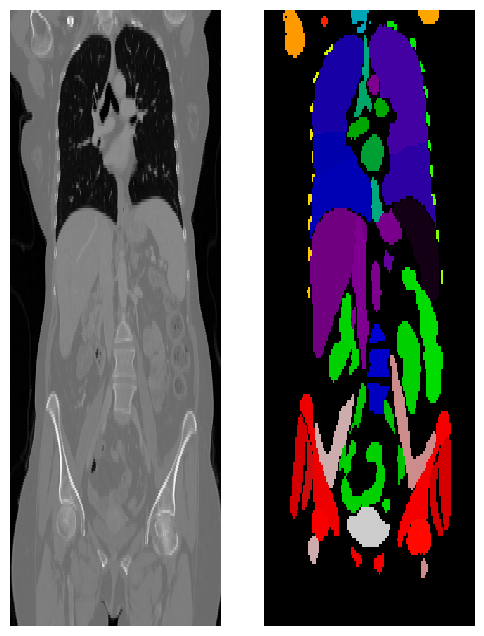

In [54]:
plt.subplots(1,2,figsize=(6,8))
plt.subplot(121)
plt.pcolormesh(CT_coronal_slice.T, cmap='Greys_r')
plt.axis('off')
plt.subplot(122)
plt.pcolormesh(segmentation_coronal_slice.T, cmap='nipy_spectral')
plt.axis('off')
plt.show()

In [55]:
number_bladder_voxels = (segmentation==13).sum().item()
voxel_volume_cm3 = np.prod(CT.meta['spacing']/10)
bladder_volume = number_bladder_voxels * voxel_volume_cm3
print(f'Bladder Volume {bladder_volume:.1f}cm^3')

Bladder Volume 940.7cm^3


In [1]:
pip install nibabel numpy trimesh scikit-image

Note: you may need to restart the kernel to use updated packages.


In [4]:
# 필수 라이브러리 임포트
import nibabel as nib
import numpy as np
import trimesh
from skimage import measure
import os
from trimesh.smoothing import filter_laplacian

# 장기 라벨과 이름 매핑
label_names = {
    0: 'background',  # 배경
    1: 'spleen',  # 비장
    2: 'right_kidney',  # 오른쪽 신장
    3: 'left_kidney',  # 왼쪽 신장
    4: 'gallbladder',  # 담낭
    5: 'liver',  # 간
    6: 'stomach',  # 위
    7: 'aorta',  # 대동맥
    8: 'inferior_vena_cava',  # 하대정맥
    9: 'portal_vein_and_splenic_vein',  # 문맥 및 비장 정맥
    10: 'pancreas',  # 췌장
    11: 'right_adrenal_gland',  # 오른쪽 부신
    12: 'left_adrenal_gland',  # 왼쪽 부신
    13: 'left_upper_lobe_lung',  # 왼쪽 상엽 폐
    14: 'left_lower_lobe_lung',  # 왼쪽 하엽 폐
    15: 'right_upper_lobe_lung',  # 오른쪽 상엽 폐
    16: 'right_middle_lobe_lung',  # 오른쪽 중엽 폐
    17: 'right_lower_lobe_lung',  # 오른쪽 하엽 폐
    18: 'vertebrae_L5',  # L5 척추
    19: 'vertebrae_L4',  # L4 척추
    20: 'vertebrae_L3',  # L3 척추
    21: 'vertebrae_L2',  # L2 척추
    22: 'vertebrae_L1',  # L1 척추
    23: 'vertebrae_T12',  # T12 척추
    24: 'vertebrae_T11',  # T11 척추
    25: 'vertebrae_T10',  # T10 척추
    26: 'vertebrae_T9',  # T9 척추
    27: 'vertebrae_T8',  # T8 척추
    28: 'vertebrae_T7',  # T7 척추
    29: 'vertebrae_T6',  # T6 척추
    30: 'vertebrae_T5',  # T5 척추
    31: 'vertebrae_T4',  # T4 척추
    32: 'vertebrae_T3',  # T3 척추
    33: 'vertebrae_T2',  # T2 척추
    34: 'vertebrae_T1',  # T1 척추
    35: 'vertebrae_C7',  # C7 척추
    36: 'vertebrae_C6',  # C6 척추
    37: 'vertebrae_C5',  # C5 척추
    38: 'vertebrae_C4',  # C4 척추
    39: 'vertebrae_C3',  # C3 척추
    40: 'vertebrae_C2',  # C2 척추
    41: 'vertebrae_C1',  # C1 척추
    42: 'esophagus',  # 식도
    43: 'trachea',  # 기관
    44: 'heart_myocardium',  # 심근
    45: 'heart_atrium_left',  # 왼쪽 심방
    46: 'heart_ventricle_left',  # 왼쪽 심실
    47: 'heart_atrium_right',  # 오른쪽 심방
    48: 'heart_ventricle_right',  # 오른쪽 심실
    49: 'pulmonary_artery',  # 폐동맥
    50: 'brain',  # 뇌
    51: 'iliac_artery_left',  # 왼쪽 장골 동맥
    52: 'iliac_artery_right',  # 오른쪽 장골 동맥
    53: 'iliac_vena_left',  # 왼쪽 장골 정맥
    54: 'iliac_vena_right',  # 오른쪽 장골 정맥
    55: 'small_bowel',  # 소장
    56: 'duodenum',  # 십이지장
    57: 'colon',  # 대장
    58: 'rib_left_1',  # 왼쪽 1번 갈비뼈
    59: 'rib_left_2',  # 왼쪽 2번 갈비뼈
    60: 'rib_left_3',  # 왼쪽 3번 갈비뼈
    61: 'rib_left_4',  # 왼쪽 4번 갈비뼈
    62: 'rib_left_5',  # 왼쪽 5번 갈비뼈
    63: 'rib_left_6',  # 왼쪽 6번 갈비뼈
    64: 'rib_left_7',  # 왼쪽 7번 갈비뼈
    65: 'rib_left_8',  # 왼쪽 8번 갈비뼈
    66: 'rib_left_9',  # 왼쪽 9번 갈비뼈
    67: 'rib_left_10',  # 왼쪽 10번 갈비뼈
    68: 'rib_left_11',  # 왼쪽 11번 갈비뼈
    69: 'rib_left_12',  # 왼쪽 12번 갈비뼈
    70: 'rib_right_1',  # 오른쪽 1번 갈비뼈
    71: 'rib_right_2',  # 오른쪽 2번 갈비뼈
    72: 'rib_right_3',  # 오른쪽 3번 갈비뼈
    73: 'rib_right_4',  # 오른쪽 4번 갈비뼈
    74: 'rib_right_5',  # 오른쪽 5번 갈비뼈
    75: 'rib_right_6',  # 오른쪽 6번 갈비뼈
    76: 'rib_right_7',  # 오른쪽 7번 갈비뼈
    77: 'rib_right_8',  # 오른쪽 8번 갈비뼈
    78: 'rib_right_9',  # 오른쪽 9번 갈비뼈
    79: 'rib_right_10',  # 오른쪽 10번 갈비뼈
    80: 'rib_right_11',  # 오른쪽 11번 갈비뼈
    81: 'rib_right_12',  # 오른쪽 12번 갈비뼈
    82: 'humerus_left',  # 왼쪽 상완골
    83: 'humerus_right',  # 오른쪽 상완골
    84: 'scapula_left',  # 왼쪽 견갑골
    85: 'scapula_right',  # 오른쪽 견갑골
    86: 'clavicula_left',  # 왼쪽 쇄골
    87: 'clavicula_right',  # 오른쪽 쇄골
    88: 'femur_left',  # 왼쪽 대퇴골
    89: 'femur_right',  # 오른쪽 대퇴골
    90: 'hip_left',  # 왼쪽 고관절
    91: 'hip_right',  # 오른쪽 고관절
    92: 'sacrum',  # 천골
    93: 'face',  # 얼굴
    94: 'gluteus_maximus_left',  # 왼쪽 대둔근
    95: 'gluteus_maximus_right',  # 오른쪽 대둔근
    96: 'gluteus_medius_left',  # 왼쪽 중둔근
    97: 'gluteus_medius_right',  # 오른쪽 중둔근
    98: 'gluteus_minimus_left',  # 왼쪽 소둔근
    99: 'gluteus_minimus_right',  # 오른쪽 소둔근
    100: 'autochthon_left',  # 왼쪽 척주기립근
    101: 'autochthon_right',  # 오른쪽 척주기립근
    102: 'iliopsoas_left',  # 왼쪽 장요근
    103: 'iliopsoas_right',  # 오른쪽 장요근
    104: 'urinary_bladder'  # 방광
}

def nifti_to_stl(nifti_file, output_dir):
    # NIfTI 파일 로드
    img = nib.load(nifti_file)
    img_data = img.get_fdata()

    # 고유 라벨 가져오기
    unique_labels = np.unique(img_data)

    # 출력 디렉토리가 존재하는지 확인하고 없으면 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 각 고유 라벨을 순회하면서 각각의 라벨에 대해 메쉬 생성
    for label in unique_labels:
        if label == 0:
            continue  # 배경은 건너뜀

        # 현재 라벨에 대한 이진 마스크 생성
        binary_mask = img_data == label

        # marching cubes 알고리즘을 사용해 메쉬 생성
        verts, faces, normals, values = measure.marching_cubes(binary_mask, 0.5)

        # 메쉬 객체 생성
        mesh = trimesh.Trimesh(vertices=verts, faces=faces)

        # Laplacian smoothing을 사용해 메쉬 부드럽게 하기
        filter_laplacian(mesh, lamb=0.5, iterations=10)

        # 메쉬를 STL 파일로 저장
        label_name = label_names.get(label, f'label_{int(label)}')
        output_file = os.path.join(output_dir, f'{label_name}.stl')
        mesh.export(output_file)
        print(f'Saved {output_file}')

# 사용 예제
nifti_file = 'C:/Users/bkyou/datadir/1.3.6.1.4.1.14519.5.2.1.1600.1201/1.3.6.1.4.1.14519.5.2.1.1600.1201_trans.nii.gz'
output_dir = 'C:/Users/bkyou/datadir/output2_stl'
nifti_to_stl(nifti_file, output_dir)


Saved C:/Users/bkyou/datadir/output_stl\spleen.stl
Saved C:/Users/bkyou/datadir/output_stl\right_kidney.stl
Saved C:/Users/bkyou/datadir/output_stl\left_kidney.stl
Saved C:/Users/bkyou/datadir/output_stl\gallbladder.stl
Saved C:/Users/bkyou/datadir/output_stl\liver.stl
Saved C:/Users/bkyou/datadir/output_stl\stomach.stl
Saved C:/Users/bkyou/datadir/output_stl\aorta.stl
Saved C:/Users/bkyou/datadir/output_stl\inferior_vena_cava.stl
Saved C:/Users/bkyou/datadir/output_stl\portal_vein_and_splenic_vein.stl
Saved C:/Users/bkyou/datadir/output_stl\pancreas.stl
Saved C:/Users/bkyou/datadir/output_stl\right_adrenal_gland.stl
Saved C:/Users/bkyou/datadir/output_stl\left_adrenal_gland.stl
Saved C:/Users/bkyou/datadir/output_stl\left_upper_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output_stl\left_lower_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output_stl\right_upper_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output_stl\right_middle_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output_stl\right_low

In [6]:
import nibabel as nib
import numpy as np
import trimesh
from skimage import measure
import os
from trimesh.smoothing import filter_laplacian

# 장기 라벨과 이름 매핑
label_names = {
    0: 'background',                   # 배경
    1: 'spleen',                       # 비장
    2: 'right_kidney',                 # 오른쪽 신장
    3: 'left_kidney',                  # 왼쪽 신장
    4: 'gallbladder',                  # 담낭
    5: 'liver',                        # 간
    6: 'stomach',                      # 위
    7: 'aorta',                        # 대동맥
    8: 'inferior_vena_cava',           # 하대정맥
    9: 'portal_vein_and_splenic_vein', # 문맥 및 비장 정맥
    10: 'pancreas',                    # 췌장
    11: 'right_adrenal_gland',         # 오른쪽 부신
    12: 'left_adrenal_gland',          # 왼쪽 부신
    13: 'left_upper_lobe_lung',        # 왼쪽 상엽 폐
    14: 'left_lower_lobe_lung',        # 왼쪽 하엽 폐
    15: 'right_upper_lobe_lung',       # 오른쪽 상엽 폐
    16: 'right_middle_lobe_lung',      # 오른쪽 중엽 폐
    17: 'right_lower_lobe_lung',       # 오른쪽 하엽 폐
    18: 'vertebrae_L5',                # L5 척추
    19: 'vertebrae_L4',                # L4 척추
    20: 'vertebrae_L3',                # L3 척추
    21: 'vertebrae_L2',                # L2 척추
    22: 'vertebrae_L1',                # L1 척추
    23: 'vertebrae_T12',               # T12 척추
    24: 'vertebrae_T11',               # T11 척추
    25: 'vertebrae_T10',               # T10 척추
    26: 'vertebrae_T9',                # T9 척추
    27: 'vertebrae_T8',                # T8 척추
    28: 'vertebrae_T7',                # T7 척추
    29: 'vertebrae_T6',                # T6 척추
    30: 'vertebrae_T5',                # T5 척추
    31: 'vertebrae_T4',                # T4 척추
    32: 'vertebrae_T3',                # T3 척추
    33: 'vertebrae_T2',                # T2 척추
    34: 'vertebrae_T1',                # T1 척추
    35: 'vertebrae_C7',                # C7 척추
    36: 'vertebrae_C6',                # C6 척추
    37: 'vertebrae_C5',                # C5 척추
    38: 'vertebrae_C4',                # C4 척추
    39: 'vertebrae_C3',                # C3 척추
    40: 'vertebrae_C2',                # C2 척추
    41: 'vertebrae_C1',                # C1 척추
    42: 'esophagus',                   # 식도
    43: 'trachea',                     # 기관
    44: 'heart_myocardium',            # 심근
    45: 'heart_atrium_left',           # 왼쪽 심방
    46: 'heart_ventricle_left',        # 왼쪽 심실
    47: 'heart_atrium_right',          # 오른쪽 심방
    48: 'heart_ventricle_right',       # 오른쪽 심실
    49: 'pulmonary_artery',            # 폐동맥
    50: 'brain',                       # 뇌
    51: 'iliac_artery_left',           # 왼쪽 장골 동맥
    52: 'iliac_artery_right',          # 오른쪽 장골 동맥
    53: 'iliac_vena_left',             # 왼쪽 장골 정맥
    54: 'iliac_vena_right',            # 오른쪽 장골 정맥
    55: 'small_bowel',                 # 소장
    56: 'duodenum',                    # 십이지장
    57: 'colon',                       # 대장
    58: 'rib_left_1',                  # 왼쪽 1번 갈비뼈
    59: 'rib_left_2',                  # 왼쪽 2번 갈비뼈
    60: 'rib_left_3',                  # 왼쪽 3번 갈비뼈
    61: 'rib_left_4',                  # 왼쪽 4번 갈비뼈
    62: 'rib_left_5',                  # 왼쪽 5번 갈비뼈
    63: 'rib_left_6',                  # 왼쪽 6번 갈비뼈
    64: 'rib_left_7',                  # 왼쪽 7번 갈비뼈
    65: 'rib_left_8',                  # 왼쪽 8번 갈비뼈
    66: 'rib_left_9',                  # 왼쪽 9번 갈비뼈
    67: 'rib_left_10',                 # 왼쪽 10번 갈비뼈
    68: 'rib_left_11',                 # 왼쪽 11번 갈비뼈
    69: 'rib_left_12',                 # 왼쪽 12번 갈비뼈
    70: 'rib_right_1',                 # 오른쪽 1번 갈비뼈
    71: 'rib_right_2',                 # 오른쪽 2번 갈비뼈
    72: 'rib_right_3',                 # 오른쪽 3번 갈비뼈
    73: 'rib_right_4',                 # 오른쪽 4번 갈비뼈
    74: 'rib_right_5',                 # 오른쪽 5번 갈비뼈
    75: 'rib_right_6',                 # 오른쪽 6번 갈비뼈
    76: 'rib_right_7',                 # 오른쪽 7번 갈비뼈
    77: 'rib_right_8',                 # 오른쪽 8번 갈비뼈
    78: 'rib_right_9',                 # 오른쪽 9번 갈비뼈
    79: 'rib_right_10',                # 오른쪽 10번 갈비뼈
    80: 'rib_right_11',                # 오른쪽 11번 갈비뼈
    81: 'rib_right_12',                # 오른쪽 12번 갈비뼈
    82: 'humerus_left',                # 왼쪽 상완골
    83: 'humerus_right',               # 오른쪽 상완골
    84: 'scapula_left',                # 왼쪽 견갑골
    85: 'scapula_right',               # 오른쪽 견갑골
    86: 'clavicula_left',              # 왼쪽 쇄골
    87: 'clavicula_right',             # 오른쪽 쇄골
    88: 'femur_left',                  # 왼쪽 대퇴골
    89: 'femur_right',                 # 오른쪽 대퇴골
    90: 'hip_left',                    # 왼쪽 고관절
    91: 'hip_right',                   # 오른쪽 고관절
    92: 'sacrum',                      # 천골
    93: 'face',                        # 얼굴
    94: 'gluteus_maximus_left',        # 왼쪽 대둔근
    95: 'gluteus_maximus_right',       # 오른쪽 대둔근
    96: 'gluteus_medius_left',         # 왼쪽 중둔근
    97: 'gluteus_medius_right',        # 오른쪽 중둔근
    98: 'gluteus_minimus_left',        # 왼쪽 소둔근
    99: 'gluteus_minimus_right',       # 오른쪽 소둔근
    100: 'autochthon_left',            # 왼쪽 척주기립근
    101: 'autochthon_right',           # 오른쪽 척주기립근
    102: 'iliopsoas_left',             # 왼쪽 장요근
    103: 'iliopsoas_right',            # 오른쪽 장요근
    104: 'urinary_bladder'             # 방광
}

def nifti_to_stl(nifti_file, output_dir):
    # Load the NIfTI file
    img = nib.load(nifti_file)
    img_data = img.get_fdata()

    # Get unique labels
    unique_labels = np.unique(img_data)

    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through each unique label and create a mesh for each label
    for label in unique_labels:
        if label == 0:
            continue  # Skip the background

        # Create a binary mask for the current label
        binary_mask = img_data == label

        # Use marching cubes to create a mesh
        verts, faces, normals, values = measure.marching_cubes(binary_mask, 0.5)

        # Create a mesh object
        mesh = trimesh.Trimesh(vertices=verts, faces=faces)

        # Smooth the mesh using Laplacian smoothing
        filter_laplacian(mesh, lamb=0.5, iterations=10)

        # Save the mesh as an STL file
        label_name = label_names.get(label, f'label_{int(label)}')
        output_file = os.path.join(output_dir, f'{label_name}.stl')
        mesh.export(output_file)
        print(f'Saved {output_file}')

# Example usage
nifti_file = 'C:/Users/bkyou/datadir/1.3.6.1.4.1.14519.5.2.1.1600.1201/1.3.6.1.4.1.14519.5.2.1.1600.1201_trans.nii.gz'
output_dir = 'C:/Users/bkyou/datadir/output2_stl'
nifti_to_stl(nifti_file, output_dir)


Saved C:/Users/bkyou/datadir/output2_stl\spleen.stl
Saved C:/Users/bkyou/datadir/output2_stl\right_kidney.stl
Saved C:/Users/bkyou/datadir/output2_stl\left_kidney.stl
Saved C:/Users/bkyou/datadir/output2_stl\gallbladder.stl
Saved C:/Users/bkyou/datadir/output2_stl\liver.stl
Saved C:/Users/bkyou/datadir/output2_stl\stomach.stl
Saved C:/Users/bkyou/datadir/output2_stl\aorta.stl
Saved C:/Users/bkyou/datadir/output2_stl\inferior_vena_cava.stl
Saved C:/Users/bkyou/datadir/output2_stl\portal_vein_and_splenic_vein.stl
Saved C:/Users/bkyou/datadir/output2_stl\pancreas.stl
Saved C:/Users/bkyou/datadir/output2_stl\right_adrenal_gland.stl
Saved C:/Users/bkyou/datadir/output2_stl\left_adrenal_gland.stl
Saved C:/Users/bkyou/datadir/output2_stl\left_upper_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output2_stl\left_lower_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output2_stl\right_upper_lobe_lung.stl
Saved C:/Users/bkyou/datadir/output2_stl\right_middle_lobe_lung.stl
Saved C:/Users/bkyou/datadir/outp